# Check tidal amplitude predictions against measurements of pressure

In [67]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV

from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart
from soda.dataio import netcdfio

from mycurrents import oceanmooring as om

import seaborn as sns
import pymc3 as pm
from theano import shared
from theano import tensor as tt
from datetime import timedelta, datetime

import matplotlib as mpl

import yaml

In [68]:
%matplotlib notebook

In [69]:
def convert_rps_time(time):
    """
    Convert the RPS time into a datetime object

    Returns in UTC time zone
    """
    tzone = time.attrs['timezone']
    dtzone = timedelta(hours=float(tzone))

    #days = map(str, time.values[:,0].astype(int))
    tint = time.values[:,0].astype(int)
    days= tint.astype(str)
    times = [datetime.strptime(xx, '%Y%m%d')-dtzone for xx in days]

    msec = time.values[:,1].tolist()
    dt = [timedelta(milliseconds=float(mm)) for mm in msec]

    return np.array([t+Dt for t,Dt in zip(times,dt)]).astype('<M8[ns]') # datetime64 object


In [112]:

def rps_nc_to_om(ncfile):
    ds = xr.open_dataset(ncfile)
    time=convert_rps_time(ds.Time)
    data = ds.WaterDepth.values
    data -= data.mean()
    return om.OceanMooring(time, data , np.array([-255]),\
                            X=ds.Longitude.values, Y=ds.Latitude.values)
dsout

OceanMooring(Nz=1, Nt=112570)
	variable:  []

In [113]:
ncfiles = [r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase2/WaterLevel/2641fbl035.c.nc',
    r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase3/WaterLevel/2641fbl044.c.nc',
    r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase4/WaterLevel/2641fbl059.c.nc',
    #r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase5/WaterLevel/2641fbl073.c.nc',
    r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase6/WaterLevel/2641fbl075.c.nc',
    r'/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase6/WaterLevel/2641fbl103.c.nc',
      ]

In [114]:
for ii,ncfile in enumerate(ncfiles):
    print(ncfile)
    if ii == 0:
        dsout = rps_nc_to_om(ncfile)
    else:
        dsout = dsout.concat(rps_nc_to_om(ncfile))

/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase2/WaterLevel/2641fbl035.c.nc
/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase3/WaterLevel/2641fbl044.c.nc
/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase4/WaterLevel/2641fbl059.c.nc
/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase6/WaterLevel/2641fbl075.c.nc
/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/NetCDF/Phase6/WaterLevel/2641fbl103.c.nc


<IPython.core.display.Javascript object>


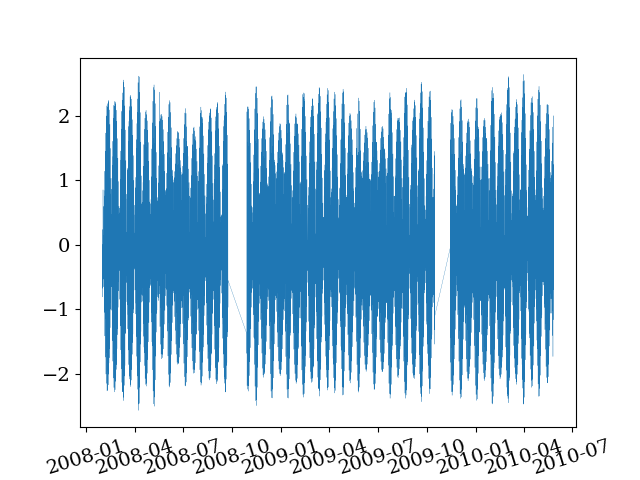

In [115]:
dsout.plot(lw=0.2)

In [121]:
xpt, ypt = float(dsout.X), float(dsout.Y)

In [122]:
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),dsout.t)


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


<IPython.core.display.Javascript object>


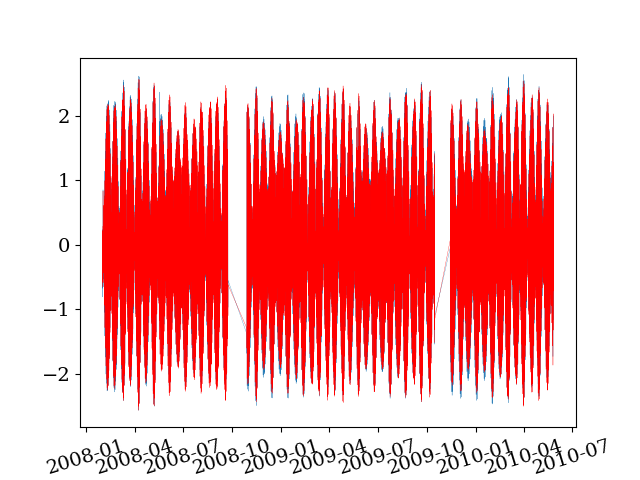

In [123]:
plt.figure()
dsout.plot(lw=0.2)
plt.plot(dsout.t, eta,'r',lw=0.2)

In [128]:
eta_ts = timeseries(dsout.t,eta)

basetime=datetime(2008,1,1)
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

etahat_amp, etahat_phs, omega,_,etahat_harmonic,_=dsout.tidefit(frqnames=tidecons,basetime=basetime)

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


In [129]:

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


<IPython.core.display.Javascript object>


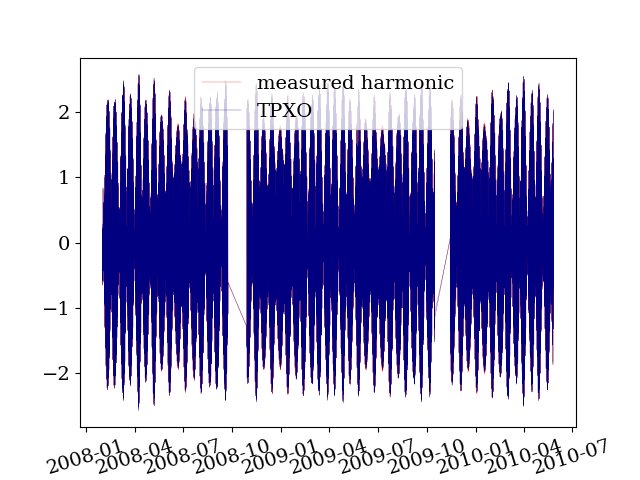

(array([733042., 733133., 733224., 733316., 733408., 733498., 733589.,
        733681., 733773., 733863., 733954.]),
 <a list of 11 Text xticklabel objects>)

In [135]:
plt.figure()
#dsout.plot(lw=0.2)
plt.plot(dsout.t, etahat_harmonic,'r',lw=0.2)
plt.plot(dsout.t, eta,'navy',lw=0.2)
plt.legend(('measured harmonic','TPXO'))
plt.xticks(rotation=17)

In [136]:
# Hilbert transform to get the signal envelope
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)


In [141]:
#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(etahat_phs.data, etahat_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re


(array([-0.4289448 , -1.13907866, -0.37718934,  0.6304551 ,  0.19926987,
         0.02651966, -0.02029788, -0.24076091, -0.27158703,  0.10367589,
         0.18105142,  0.02733152, -0.08094047, -0.00243779, -0.0328303 ,
         0.02378649]),
 array([-0.4289448 , -0.37718934,  0.19926987, -0.02029788, -0.27158703,
         0.18105142, -0.08094047, -0.0328303 ]))

In [149]:
tsec = SecondsSince(dsout.t,basetime=basetime)

h_env = sine_model_envelope(beta_s, omega, tsec)

h_D2 = sine_model_envelope(beta_s[0:8], omega[0:4], tsec)
h_D1 = sine_model_envelope(beta_s[8:], omega[4:], tsec)

<IPython.core.display.Javascript object>


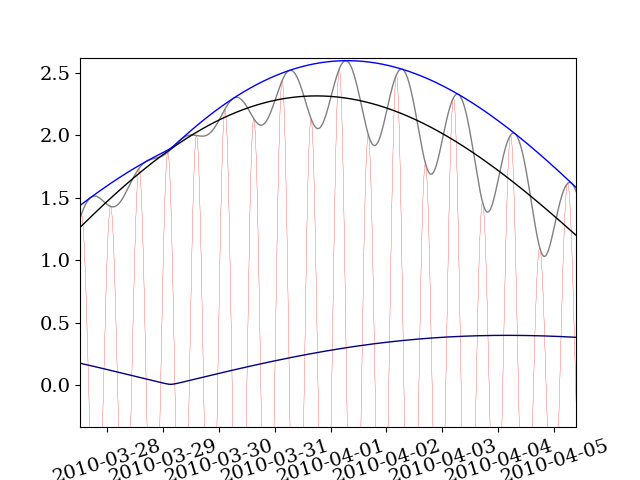

(array([733042., 733133., 733224., 733316., 733408., 733498., 733589.,
        733681., 733773., 733863., 733954.]),
 <a list of 11 Text xticklabel objects>)

In [151]:
plt.figure()
plt.plot(dsout.t, etahat_harmonic,'r',lw=0.2)
plt.plot(dsout.t, h_env,'0.5',lw=1)

plt.plot(dsout.t, h_D2,'k',lw=1)
plt.plot(dsout.t, h_D1,'navy',lw=1)
plt.plot(dsout.t, h_D1+h_D2,'b',lw=1)

plt.xticks(rotation=17)